### Imports and visualization parameters

In [ ]:
import xarray as xr
from pathlib import Path
import numpy as np
import yaml
import matplotlib.pyplot as plt
import datetime as dt
import calendar
from utils import inference
import math
from matplotlib import colormaps

# change these
model = "graphcast" # model to visualize output from, options: "sfno", "graphcast"
plot_var = "MSL" # variable to plot, options: "SP" (surface pressure) or "MSL" (mean sea level pressure) for SFNO, only "MSL" for GraphCast
cmap_str = "Set2" # options here: matplotlib.org/stable/tutorials/colors/colormaps.html
day_interval_x_ticks = 3 # how many days between x-ticks on the plot
title = f"Global Mean Pressure Trends\n{model.upper()} vs. ERA5"
save_title = f"{plot_var.lower()}_trends_{model}_era5.png"
ylab = "Surface Pressure (hPa)" if plot_var == "SP" else "Mean Sea Level Pressure (hPa)"
linewidth = 2
fontsize = 24
smallsize = 20

### Load experiment configuration file

In [12]:
# read configuration
this_dir = Path.cwd()
config_path = this_dir / "0.config.yaml"
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

# set up directories
exp_dir = Path(config["experiment_dir"]) / config["experiment_name"] # all data for experiment stored here
exp_dir.mkdir(parents=True, exist_ok=True) # make dir if it doesn't exist
era5_pressure_path = exp_dir / "era5_pressure.nc" # where to save cached ERA5 data
data_path = exp_dir / f"{model}_output.nc" # where to save output from inference
e5_base = "/glade/campaign/collections/rda/data/ds633.0/"

ic_dates = [dt.datetime.strptime(str_date, "%Y/%m/%d %H:%M") for str_date in config["ic_dates"]]
lead_times = np.arange(0, config["n_timesteps"] + 1) * 6  # in hours
n_ics = len(ic_dates)
n_timesteps = config["n_timesteps"]

### Load model output

In [13]:
print(f"Loading data from {data_path}")
ds = xr.open_dataset(data_path)
ds = ds.assign_attrs({"time units": "hours since start"})

Loading data from /glade/u/home/jmelms/projects/dcmip2025_idealized_tests/experiments/A.mass_conservation/data/test_sfno_msl/graphcast_output.nc


### Load ERA5 pressure data for comparison

In [14]:
# check to see if the data is already cached
cached = True
if era5_pressure_path.exists():
    e5_pds = xr.open_dataset(era5_pressure_path)
    # check whether the cached data has at least as many timesteps as the model output
    if len(e5_pds.init_time) < n_ics:
        print(f"Cached data has only {len(e5_pds.init_time)} timesteps, will re-download.")
        cached = False
        
    # check whether the cached data has the same initial conditions as the model output
    for ic_date in ic_dates:
        # check whether all dates are in the cached data
        if np.datetime64(ic_date) not in e5_pds.init_time.values:
            print(f"Missing data for {ic_date}, will re-download.")
            cached = False
            break
        
    print(f"Loaded cached data from {era5_pressure_path} with {len(e5_pds.init_time)} timesteps.")
    
else:
    cached = False
    
if not cached:
    print(f"Loading ERA5 pressure data from {e5_base}")

    # path to the ERA5 pressure data
    sp_template = f"{e5_base}/e5.oper.an.sfc/{{year:04}}{{month:02}}/e5.oper.an.sfc.128_134_sp.ll025sc.{{year:04}}{{month:02}}0100_{{year:04}}{{month:02}}{{dayend:02}}23.nc"
    msl_template = f"{e5_base}/e5.oper.an.sfc/{{year:04}}{{month:02}}/e5.oper.an.sfc.128_151_msl.ll025sc.{{year:04}}{{month:02}}0100_{{year:04}}{{month:02}}{{dayend:02}}23.nc"
    pressure_dict = {}
    for ic_date in ic_dates:
        keep_times = ic_date + dt.timedelta(hours=6) * np.arange(n_timesteps+1)
        pressure_files = []
        # necessary in case the user requests inference that spans multiple months
        year_months = set((t.year, t.month) for t in keep_times)
        for year, month in year_months:
            dayend = calendar.monthrange(year, month)[1]
            sp_file = sp_template.format(year=year, month=month, dayend=dayend)
            msl_file = msl_template.format(year=year, month=month, dayend=dayend)
            pressure_files.append(sp_file)
            pressure_files.append(msl_file)

        pds = xr.open_mfdataset(pressure_files, parallel=True)
        pds = pds.sel(time=keep_times).squeeze()
        sp_latmean = inference.latitude_weighted_mean(pds["SP"], pds["latitude"]) / 100 # convert to hPa
        msl_latmean = inference.latitude_weighted_mean(pds["MSL"], pds["latitude"]) / 100 # convert to hPa
        pressure_dict[ic_date] = xr.Dataset(
            data_vars={
                "SP": (["lead_time"], sp_latmean.values),
                "MSL": (["lead_time"], msl_latmean.values),
            },
            coords={
                "init_time": ic_date,
                "lead_time": lead_times,
            }
        )
        print(f"Loaded pressure for {ic_date} with shape {pds['SP'].shape}")

    print(f"Caching the ERA5 data for {len(ic_dates)} start dates.")
    # combine the data into a single xarray dataset
    e5_pds = xr.concat([pressure_dict[ic] for ic in ic_dates], dim="init_time")
    e5_pds["SP_mean"] = e5_pds["SP"].mean(dim="init_time")
    e5_pds["MSL_mean"] = e5_pds["MSL"].mean(dim="init_time")

    # cache the data for quicker visualizations in the future
    e5_pds.to_netcdf(era5_pressure_path, mode="w", format="NETCDF4", engine="netcdf4")

Loaded cached data from /glade/u/home/jmelms/projects/dcmip2025_idealized_tests/experiments/A.mass_conservation/data/test_sfno_msl/era5_pressure.nc with 2 timesteps.


### Make figure

Saved figure to /glade/u/home/jmelms/projects/dcmip2025_idealized_tests/experiments/A.mass_conservation/data/test_sfno_msl/msl_trends_graphcast_era5.png


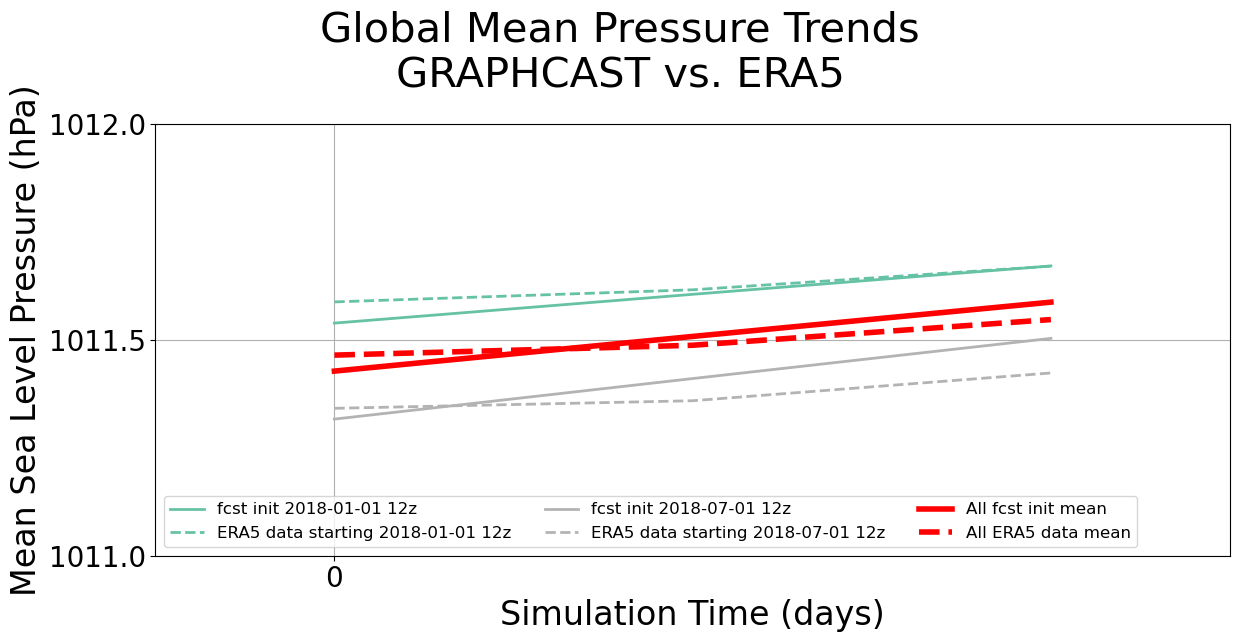

In [15]:
cmap = colormaps.get_cmap(cmap_str)
qual_colors = cmap(np.linspace(0, 1, n_ics))

fig, ax = plt.subplots(figsize=(12.5, 6.5))
for i, ic in enumerate(ic_dates):
    model_linedat = ds[f"MEAN_{plot_var}"].isel(init_time=i).squeeze()
    e5_linedat = e5_pds[plot_var].isel(init_time=i).squeeze()
    color = qual_colors[i]
    ax.plot(lead_times, model_linedat, color=color, linewidth=linewidth, label=f"fcst init {ic.strftime('%Y-%m-%d %Hz')}", linestyle="-")
    ax.plot(lead_times, e5_linedat, color=color, linewidth=linewidth, label=f"ERA5 data starting {ic.strftime('%Y-%m-%d %Hz')}", linestyle="--")
    
ens_mean = ds[f"IC_MEAN_{plot_var}"].squeeze()
ax.plot(lead_times, ens_mean, color="red", linewidth=2*linewidth, label="All fcst init mean", linestyle="-")
ax.plot(lead_times, e5_pds[f"{plot_var}_mean"], color="red", linewidth=2*linewidth, label="All ERA5 data mean", linestyle="--")
   
ax.set_xticks(lead_times[::4*day_interval_x_ticks], (lead_times[::4*day_interval_x_ticks]//(24)), fontsize=smallsize)
yticks = np.arange(math.floor(ens_mean.min()), math.ceil(ens_mean.max())+0.5, 0.5)
ax.set_yticks(yticks, yticks, fontsize=smallsize)
ax.set_xlabel("Simulation Time (days)", fontsize=fontsize)
ax.set_ylabel(ylab, fontsize=fontsize)
ax.set_xlim(xmin=-3, xmax=lead_times[-1]+3)
fig.suptitle(title, fontsize=30)
ax.grid()
ax.set_facecolor("#FFFFFF")
fig.tight_layout()
plt.legend(fontsize=12, loc="lower left", ncols=3)
plt.savefig(exp_dir / save_title, dpi=300, bbox_inches="tight")
print(f"Saved figure to {exp_dir / save_title}")